# 6章：要約

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="2.0.0")
dataset["train"].column_names

In [2]:
#sample_text = dataset["train"][1]["article"][:2000]
sample_text =   "We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future. \
Once you start working in the community, you are not only required to solve the problem of your clients or others, \
but also to spot or suggest a potential issue which even the client doesn’t notice. When you write a bachelor/master thesis, \
you also need to explore the unsolved problems by yourself, address them by all possible means to search for a solution, and give your findings back to the society. \
Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/works, and to appeal to others, \
which would be useful anywhere in the society. There is always someone who has been conducting a related study in the world. \
Whenever you advance your research, you will face challenges from the world. For this reason, even when you write a bachelor/master thesis, \
you should set the research topic bearing in mind the need to present the findings of your research in international conferences or journals. \
The laboratory has diverse people with various hobbies, skills, and thoughts; we respect the individuality of each member, learn from others, and have fun together. \
We hope that your experiences in the laboratory will be invaluable for the rest of your lives."
summaries = {}
sample_text

'We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future. Once you start working in the community, you are not only required to solve the problem of your clients or others, but also to spot or suggest a potential issue which even the client doesn’t notice. When you write a bachelor/master thesis, you also need to explore the unsolved problems by yourself, address them by all possible means to search for a solution, and give your findings back to the society. Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/works, and to appeal to others, which would be useful anywhere in the society. There is always someone who has been conducting a related study in the world. Whenever you advance your research, you will face challenges from the world. For this reason, even when you write a bachelor/master thesis, you should set th

In [3]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/hattori-k/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n" #GPT-2で要約をする際の接尾辞
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

vocab_file vocab.json
merges_file merges.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [5]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

vocab_file spiece.model
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


/home/hattori-k/transformers/src/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

vocab_file vocab.json
merges_file merges.txt
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [7]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

vocab_file spiece.model
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [8]:
for model_name in summaries:
    print(model_name)
    print(summaries[model_name])
    print("")

gpt2
Experimentation may make you smarter, but it doesn't make you better
The scientific method gives the scientific community the opportunity to do practical work.
There will be many people working in the community, both inside and outside of the laboratory.
If you don't have experience or skills in research, try to read a research lab manual first.
Work in the laboratory will require to get used to working with people and making practical solutions as they are needed.

t5
we hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future .
the laboratory has diverse people with various hobbies, skills, and thoughts .

bart
We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future.
Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/w

### 評価指標

In [9]:
from datasets import load_metric
import pandas as pd
import numpy as np

bleu_metric = load_metric("sacrebleu")
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1
sys_len,6
ref_len,6


### 要約モデルの学習

In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
split_lengths

In [14]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print(pipe_out[0])
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


vocab_file spiece.model
tokenizer_file tokenizer.json
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


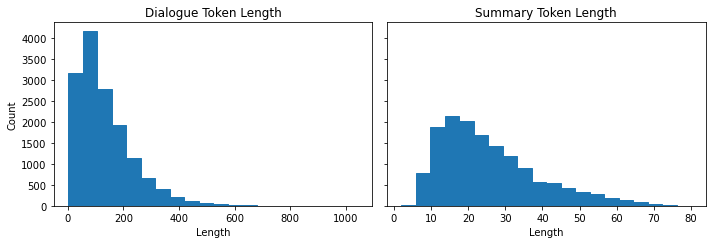

In [17]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)

# エンコーダーの入力とデコーダーの入力のトークン化の区別
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    
    return {"input_ids": input_encodings["input_ids"], "attention_mask": input_encodings["attention_mask"], "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)